In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

## Read the Data

In [ ]:
df1 = pd.read_csv("data/train_data.csv")

## Number of Transactions

In [ ]:
print("Number of rows = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['label'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['label'] == 0])))

## Sample Data

In [ ]:
df1.head()

## Data Preprocessing

In [ ]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


## Fradulent transactions per card id

In [ ]:
df2 = df1[['card_id','label']].groupby(['card_id']).sum().sort_values(['label'], ascending=False)

print(f"Cards with frauds committed: {len(df2.loc[df2['label'] > 0])}")

df2.head()

In [ ]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df2.index,y=df2['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Fradulent transactions per IP

In [ ]:
df3 = df1[['ip_id','label']].groupby(['ip_id']).sum().sort_values(['label'], ascending=False)

print(f"IPs with frauds committed: {len(df3.loc[df3['label'] > 0])}")

df3.head()

In [ ]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df3.index,y=df3['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Data Preprocessing

In [ ]:
df1 = pd.read_csv("data/train_data.csv")

# Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)


def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']] * 100)


df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account', '', x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1.loc[df1['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False, 'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True, 'countries_equal'] = 1

X = df1[['issuercountrycode',
         'txvariantcode',
         'bin',
         'amount',
         'currencycode',
         'shoppercountrycode',
         'shopperinteraction',
         'cardverificationcodesupplied',
         'cvcresponsecode',
         'accountcode',
         'mail_id',
         'ip_id',
         'card_id',
         'amount_eur',
         'countries_equal']
]


## Heat Maps

In [ ]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

sns.heatmap(df1.query('label==1').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax1, cmap='YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('label==0').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax2, cmap='YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1, figsize=(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')

plt.show()

## Heat Maps

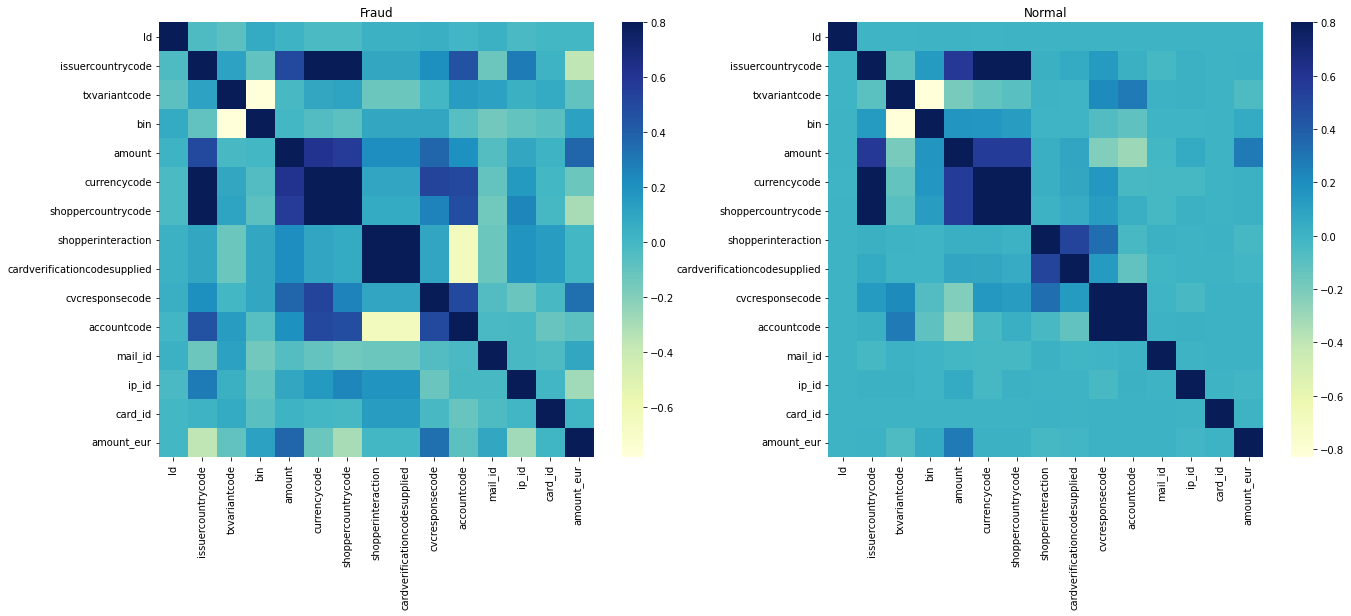

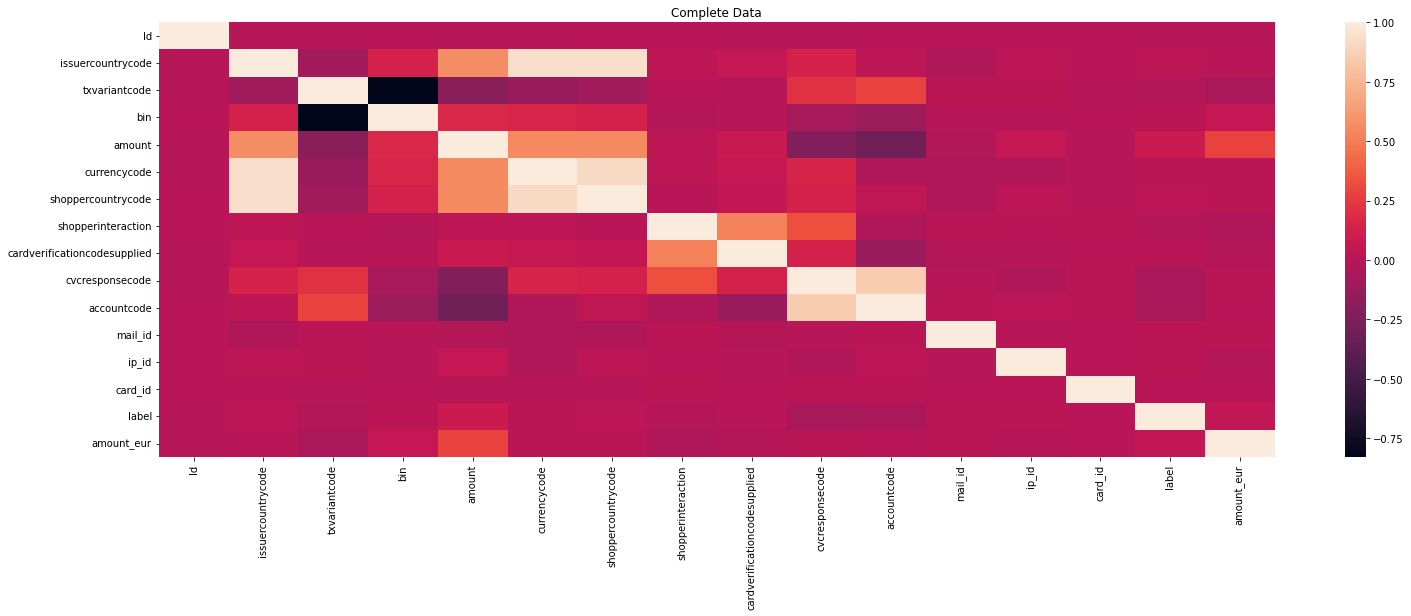

In [23]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df1.query('label==1').drop('label',axis='columns').corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('label==0').drop('label',axis='columns').corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')

plt.show()